## Anticancer Peptides Classification Using Long-Short-Term Memory with Novel Feature Representation

Import Libraries

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GRU, SimpleRNN
from keras import initializers
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pickle
import scipy.io as sio
import numpy as np
from numpy import linalg as la
import argparse
from keras.utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score
import tensorflow
import re
import pandas as pd
!pip install wget
import wget

Load Datasets and feature extraction functions

In [2]:
feature_extraction = wget.download('https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/feature_extraction.py')
acp740_path = 'https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/data/acp740.txt'
name_740 = acp740_path.split('https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/data/')[1]
acp740 = tensorflow.keras.utils.get_file(name_740, acp740_path)

from feature_extraction import *

Main function 'Train_Evaluate_ACP_classifier' to perform training and validation for given number of k-folds on 

In [3]:
def Train_Evaluate_ACP_classifier(path, gap1=4,gap2=4, folds = 5):
    # define parameters
    timesteps = 1
    batch_size = 64
    epochs = 30

    # get data
    [DataX, LabelY] = proposed_features(load_sequences(path), gap1=gap1,gap2=gap2) # proposed novel features
    bpf, kmer, label = ACP_DL_feature(path)  # features from ACP-DL method
    X = np.concatenate((bpf, kmer), axis=1) # k-mer with binary
    X = np.concatenate((X, DataX), axis=1)  # add side chain
    data_dim = len(X[0])
    #  expected input data shape: (batch_size, timesteps, data_dim)
    X = np.reshape(X, (len(X), timesteps, data_dim))

    stats = []

    num_cross_val = folds  # 5-fold
    all_labels = []
    all_prob = {}
    all_prob[0] = []

    for fold in range(num_cross_val):
        train = np.array([x for i, x in enumerate(X) if i % num_cross_val != fold])
        test = np.array([x for i, x in enumerate(X) if i % num_cross_val == fold])
        train_label = np.array([x for i, x in enumerate(label) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(label) if i % num_cross_val == fold])
        real_labels = []
        for val in test_label:
            if val == 1:
                real_labels.append(1)
            else:
                real_labels.append(0)

        train_label_new = []
        for val in train_label:
            if val == 1:
                train_label_new.append(1)
            else:
                train_label_new.append(0)
        all_labels = all_labels + real_labels

        model = Sequential()
        model.add(LSTM(128, return_sequences=False,input_shape=(timesteps, data_dim), name='lstm1'))  # returns a sequence of vectors of dimension 32
        model.add(Dropout(0.25, name='dropout'))
        model.add(Dense(1, name='full_connect'))
        model.add(Activation('sigmoid'))
        model.summary()

        print('Compiling the Model...')
        model.compile(loss='binary_crossentropy',  #
              optimizer='adam',
              metrics=['accuracy'])

        print("Train...")

        model.fit(train, train_label, batch_size=batch_size,epochs=epochs, verbose=0)

        lstm_proba = model.predict(test)
        all_prob[0] = all_prob[0] + [val for val in lstm_proba]
        y_pred_xgb = transfer_label_from_prob(lstm_proba)

        t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(test_label,y_pred_xgb)
        stats.append([t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1])

        print(t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1)
        print('---' * 30)

    mean_stat={}
    mean_stat['Sn']=np.mean(stats,axis=0)[0]
    mean_stat['Sp']=np.mean(stats,axis=0)[1]
    mean_stat['Acc']=np.mean(stats,axis=0)[2]
    mean_stat['Bal.Acc.']=np.mean(stats,axis=0)[3]
    mean_stat['MCC']=np.mean(stats,axis=0)[4]
    mean_stat['YI']=np.mean(stats,axis=0)[5]
    mean_stat['F1-score']=np.mean(stats,axis=0)[6]
    print('Mean stats:')
    print(mean_stat)

    std_stat={}
    std_stat['Sn']=np.std(stats,axis=0)[0]
    std_stat['Sp']=np.std(stats,axis=0)[1]
    std_stat['Acc']=np.std(stats,axis=0)[2]
    std_stat['Bal.Acc.']=np.std(stats,axis=0)[3]
    std_stat['MCC']=np.std(stats,axis=0)[4]
    std_stat['YI']=np.std(stats,axis=0)[5]
    std_stat['F1-score']=np.std(stats,axis=0)[6]
    print('\nStd stats:')
    print(std_stat)
    print('---' * 30)

    '''
    print('Mean stats:')
    print(np.mean(stats,axis=0))
    print('Std stats:')
    print(np.std(stats,axis=0))
    '''
    plot_roc_curve(all_labels, all_prob[0], 'proposed method')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    #plt.savefig( f'{i}' +' plot.jpg')
    plt.show()
    plt.close()

num pos: 376 num neg: 364


d:\anaconda3\envs\Py3126\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 128)            │       389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_connect (Dense)            │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.8026315789473685 0.8472222222222222 0.8243243243243243 0.8249269005847953 0.6498538011695907 0.6498538011695907 0.8243243243243243
------------------------------------------------------------------------------------------


d:\anaconda3\envs\Py3126\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 128)            │       389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_connect (Dense)            │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.9066666666666666 0.863013698630137 0.8851351351351351 0.8848401826484018 0.770736893406094 0.7696803652968036 0.8888888888888888
------------------------------------------------------------------------------------------


d:\anaconda3\envs\Py3126\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 128)            │       389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_connect (Dense)            │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002722CF9D260> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.8933333333333333 0.8493150684931506 0.8716216216216216 0.871324200913242 0.7436678235854718 0.7426484018264841 0.8758169934640523
----------------------------------

d:\anaconda3\envs\Py3126\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 128)            │       389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_connect (Dense)            │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.8666666666666667 0.863013698630137 0.8648648648648649 0.8648401826484018 0.7296803652968037 0.7296803652968036 0.8666666666666667
------------------------------------------------------------------------------------------


d:\anaconda3\envs\Py3126\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 128)            │       389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ full_connect (Dense)            │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.9733333333333334 0.8493150684931506 0.9121621621621622 0.9113242009132421 0.8301884559324813 0.8226484018264841 0.9182389937106918
------------------------------------------------------------------------------------------
Mean stats:
{'Sn': 0.8885263157894737, 'Sp': 0.8543759512937594, 'Acc': 0.8716216216216216, 'Bal.Acc.': 0.8714511335416166, 'MCC': 0.7448254678780882, 'YI': 0.7429022670832331, 'F1-score': 0.8747871734109248}

Std stats:
{'Sn': 0.05549803609002019, 'Sp': 0.0070939730358403254, 'Acc': 0.02866649112918435, 'Bal.Acc.': 0.0282040889710386, 'MCC': 0.05866612898830744, 'YI': 0.0564081779420772, 'F1-score': 0.03066079374004227}
------------------------------------------------------------------------------------------


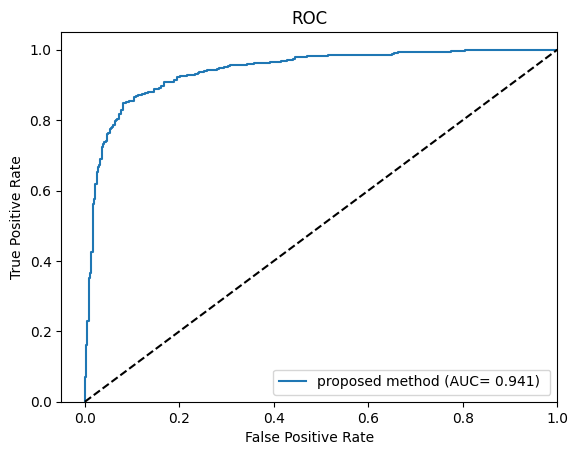

In [4]:
Train_Evaluate_ACP_classifier(acp740, gap1=1,gap2=5, folds = 5)